In [93]:
import numpy as np
import pandas as pd
from PyEMD import EMD, Visualisation
import scipy
import math
import scipy.io
import scipy.linalg

import sklearn.metrics
import sklearn.neighbors
from sklearn import metrics
from sklearn import svm

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset

import ipdb

# Utils

In [86]:
def normalize(V):
    return ( V - min(V.flatten()) ) / ( max(V.flatten()) - min(V.flatten()) )


def sliding_window(T, T_org, seq_len, label_seq_len):

    # seq_len is equal to window_size
    # T (np.array) has dim: population, seq_len (window length)
    TT = T.reshape(-1, 1)
    K = TT.shape[0] - seq_len - label_seq_len + 1  # Li, et al., 2021, TRJ part C, pp. 8
    
    TT_org = T_org.reshape(-1, 1)

    # TT has dim: n, 1
    # assemble the data into 2D
    x_set = np.vstack(TT[i : K+i, 0] for i in range(seq_len)).T
    y_set = np.vstack(TT_org[i+seq_len : K+seq_len+i, 0] for i in range(label_seq_len)).T
    
    assert x_set.shape[0] == y_set.shape[0]

    # return size: n_samp, seq_len
    return x_set, y_set


def var_name(var, all_var=locals()):
    # get the name of the variable
    return [var_name for var_name in all_var if all_var[var_name] is var][0]


def np2csv(A):
    # store numpy to local csv file
    if type(A) == torch.Tensor:
        np.savetxt(var_name(A)+'.csv', A.detach().numpy(), delimiter=',')
    elif type(A) == np.ndarray:
        np.savetxt(var_name(A)+'.csv', A, delimiter=',')

# 1. BDA Part
## 1.a. Define BDA methodology

In [3]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(
                np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(
                np.asarray(X1).T, None, gamma)
    return K


def proxy_a_distance(source_X, target_X):
    """
    Compute the Proxy-A-Distance of a source/target representation
    """
    nb_source = np.shape(source_X)[0]
    nb_target = np.shape(target_X)[0]

    train_X = np.vstack((source_X, target_X))
    train_Y = np.hstack((np.zeros(nb_source, dtype=int),
                         np.ones(nb_target, dtype=int)))

    clf = svm.LinearSVC(random_state=0)
    clf.fit(train_X, train_Y)
    y_pred = clf.predict(train_X)
    error = metrics.mean_absolute_error(train_Y, y_pred)
    dist = 2 * (1 - 2 * error)
    return dist


def estimate_mu(_X1, _Y1, _X2, _Y2):
    adist_m = proxy_a_distance(_X1, _X2)
    C = len(np.unique(_Y1))
    epsilon = 1e-3
    list_adist_c = []
    for i in range(1, C + 1):
        ind_i, ind_j = np.where(_Y1 == i), np.where(_Y2 == i)
        Xsi = _X1[ind_i[0], :]
        Xtj = _X2[ind_j[0], :]
        adist_i = proxy_a_distance(Xsi, Xtj)
        list_adist_c.append(adist_i)
    adist_c = sum(list_adist_c) / C
    mu = adist_c / (adist_c + adist_m)
    if mu > 1:
        mu = 1
    if mu < epsilon:
        mu = 0
    return mu

In [77]:
class BDA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, mu=0.5, gamma=1, T=10, mode='BDA', estimate_mu=False):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param mu: mu. Default is -1, if not specificied, it calculates using A-distance
        :param gamma: kernel bandwidth for rbf kernel
        :param T: iteration number
        :param mode: 'BDA' | 'WBDA'
        :param estimate_mu: True | False, if you want to automatically estimate mu instead of manally set it
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.mu = mu
        self.gamma = gamma
        self.T = T
        self.mode = mode
        self.estimate_mu = estimate_mu

    def fit(self, Xs, Ys, Xt, Yt):
        '''
        Transform and Predict using 1NN as JDA paper did
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: acc, y_pred, list_acc
        '''
        #ipdb.set_trace()
        list_acc = []
        X = np.hstack((Xs.T, Xt.T))  # X.shape: [n_feature, ns+nt]
        X /= np.linalg.norm(X, axis=0)  # why it's axis=0?
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        C = len(np.unique(Ys))
        H = np.eye(n) - 1 / n * np.ones((n, n))
        mu = self.mu
        M = 0
        Y_tar_pseudo = None
        Xs_new = None
        for t in range(self.T):
            N = 0
            M0 = e * e.T * C
            if Y_tar_pseudo is not None and len(Y_tar_pseudo) == nt:
                for c in range(1, C + 1):
                    e = np.zeros((n, 1))
                    Ns = len(Ys[np.where(Ys == c)])
                    Nt = len(Y_tar_pseudo[np.where(Y_tar_pseudo == c)])

                    if self.mode == 'WBDA':
                        Ps = Ns / len(Ys)
                        Pt = Nt / len(Y_tar_pseudo)
                        alpha = Pt / Ps
                        mu = 1
                    else:
                        alpha = 1

                    tt = Ys == c
                    e[np.where(tt == True)] = 1 / Ns
                    yy = Y_tar_pseudo == c
                    ind = np.where(yy == True)
                    inds = [item + ns for item in ind]
                    e[tuple(inds)] = -alpha / Nt
                    e[np.isinf(e)] = 0  # ？
                    N = N + np.dot(e, e.T)

            # In BDA, mu can be set or automatically estimated using A-distance
            # In WBDA, we find that setting mu=1 is enough
            if self.estimate_mu and self.mode == 'BDA':
                if Xs_new is not None:
                    mu = estimate_mu(Xs_new, Ys, Xt_new, Y_tar_pseudo)
                else:
                    mu = 0
            M = (1 - mu) * M0 + mu * N
            M /= np.linalg.norm(M, 'fro')
            K = kernel(self.kernel_type, X, None, gamma=self.gamma)
            n_eye = m if self.kernel_type == 'primal' else n
            a, b = np.linalg.multi_dot(
                [K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
            w, V = scipy.linalg.eig(a, b)
            ind = np.argsort(w)
            A = V[:, ind[:self.dim]]
            Z = np.dot(A.T, K)
            Z /= np.linalg.norm(Z, axis=0)  # why it's axis=0?
            Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
            
            '''
            clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
            clf.fit(Xs_new, Ys.ravel())
            Y_tar_pseudo = clf.predict(Xt_new)
            acc = sklearn.metrics.accuracy_score(Yt, Y_tar_pseudo)
            list_acc.append(acc)
            print('{} iteration [{}/{}]: Acc: {:.4f}'.format(self.mode, t + 1, self.T, acc))
            '''
        return Xs_new, Xt_new, A  #, acc, Y_tar_pseudo, list_acc

## 1.b. Load Data

In [199]:
weekdays = np.array([np.arange(2+7*i,7+7*i,1) for i in range(4)]).flatten()
weekends = np.array([np.arange(7+7*i,9+7*i,1) for i in range(3)]).flatten()[:-1]

src_domain = np.array(pd.read_csv('../TCA_traffic/data/siteM4_2168B_20210101_20210131.csv'))[np.array([5,6,7,8]), :]
data_target = np.array(pd.read_csv('../TCA_traffic/data/siteM4_2188B_20210101_20210131.csv'))[20:25, :]

date_choosen = 10
num_test_day = 4
#tar_domain = data_target[weekdays[date_choosen:date_choosen+1 + num_test_day], :].reshape(-1, 96)
tar_domain = data_target.copy()
tgt_validation = tar_domain[1:num_test_day+1, :]

Xs = normalize(src_domain.flatten())
Xt = normalize(tar_domain.flatten())

## 1.d. Hyperparameters

In [200]:
label_seq_len = 1
# batch_size = full batch
seq_len = 10
reduced_dim = 1
inp_dim = seq_len
label_dim = seq_len
hid_dim = 64
layers = 3
lamb = 3

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb}
hyper = pd.DataFrame(hyper, index=['Values'])

In [201]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb
Values,10,10,1,10,1,64,3,3


## 1.e. Apply BDA and get $Xs_{new}$, $Xt_{new}$ 

In [202]:
Xs, Ys = sliding_window(Xs, Xs, seq_len, label_seq_len)
Xt, Yt = sliding_window(Xt, Xt, seq_len, label_seq_len)

inp_dim -= reduced_dim
label_dim -= reduced_dim

C:\Users\10169\.conda\envs\bda_traff\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  app.launch_new_instance()
C:\Users\10169\.conda\envs\bda_traff\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [203]:
Xs.shape

(374, 10)

In [204]:
bda = BDA(kernel_type='linear', dim=inp_dim, lamb=lamb, mu=0.5, gamma=1)
Xs_new, Xt_new, A = bda.fit(Xs, Ys, Xt, Yt)  # input shape: ns, n_feature | ns, 1
Xt_new_valid = Xt_new.copy()[int(96):, :]
Xt_new = Xt_new.copy()[:int(96), :]
Yt_valid = Yt.copy()[int(96):, :]
Yt = Yt.copy()[:int(96), :]

print(Xs_new.shape)
print(Xt_new.shape)
print(Xt_new_valid.shape)

np2csv(Xs_new)
np2csv(Xt_new)

(374, 9)
(96, 9)
(374, 9)


# 2. Learning Part

## 2.a. Build network

In [205]:
class LSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, hid_dim, layers):
        super(LSTM, self).__init__()

        self.out_dim = out_dim
        
        self.lstm = nn.LSTM(inp_dim, hid_dim, layers, dropout=0.3, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim*2),
            nn.ReLU(),
            nn.Linear(hid_dim*2, out_dim)
        )  # regression
    
    def forward(self, x):
        # input: (batchsize, seq_len, input_dim)
        # output: (batchsize, seq_len, hid_dim)
        #ipdb.set_trace()
        y = self.lstm(x)[0]  # y, (h, c) = self.rnn(x)
        
        y = self.fc(y[:, :, :])  # fully connected layer
        
        return y[:, -1, :]

## 2.b. Assemble Dataloader

In [206]:
Xt_new.shape

(96, 9)

In [207]:
batch_size = 960

train_x = np.vstack([Xs_new, Xt_new])[:, :, np.newaxis]
train_y = np.vstack([Ys, Yt])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
train_y = torch.tensor(train_y, dtype=torch.float32).to(device)
Xt_new_valid = torch.tensor(Xt_new_valid[:, :, np.newaxis], dtype=torch.float32).to(device)
Yt_valid = torch.tensor(Yt_valid, dtype=torch.float32).to(device)

train_dataset = TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
train_iter = iter(train_loader)

## 2.c. Learn

In [208]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = LSTM(1, 1, hid_dim, layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 0.7)

In [209]:
data.shape

torch.Size([86, 9, 1])

In [210]:
# train
net.train()

epoches = 1000
train_loss_set = []
val_loss_set = []

for e in range(epoches):
    for i in range(len(train_loader)):
        try:
            data, label = train_iter.next()
        except:
            train_iter = iter(train_loader)
            data, label = train_iter.next()
        
        out = net(data)
        loss = criterion(out, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        val_out = net(Xt_new_valid)
        val_loss = criterion(val_out, Yt_valid)
        
        val_loss_set.append(val_loss.cpu().detach().numpy())
        train_loss_set.append(loss.cpu().detach().numpy())
    if e%20==0:
        print('Epoch No. %i success, loss: %.5f, val loss: %.5f'%(e, loss.cpu().detach().numpy(), val_loss.cpu().detach().numpy()))

Epoch No. 0 success, loss: 0.17760, val loss: 0.11487
Epoch No. 20 success, loss: 0.05646, val loss: 0.05858
Epoch No. 40 success, loss: 0.04847, val loss: 0.04221
Epoch No. 60 success, loss: 0.04859, val loss: 0.04094
Epoch No. 80 success, loss: 0.04848, val loss: 0.04184
Epoch No. 100 success, loss: 0.04808, val loss: 0.04198
Epoch No. 120 success, loss: 0.03959, val loss: 0.03794
Epoch No. 140 success, loss: 0.03180, val loss: 0.03235
Epoch No. 160 success, loss: 0.03130, val loss: 0.03017
Epoch No. 180 success, loss: 0.03089, val loss: 0.03113
Epoch No. 200 success, loss: 0.03024, val loss: 0.03204
Epoch No. 220 success, loss: 0.03015, val loss: 0.03305
Epoch No. 240 success, loss: 0.02999, val loss: 0.03299
Epoch No. 260 success, loss: 0.02972, val loss: 0.03262
Epoch No. 280 success, loss: 0.02991, val loss: 0.03255
Epoch No. 300 success, loss: 0.02957, val loss: 0.03369
Epoch No. 320 success, loss: 0.02885, val loss: 0.03347
Epoch No. 340 success, loss: 0.02892, val loss: 0.0326

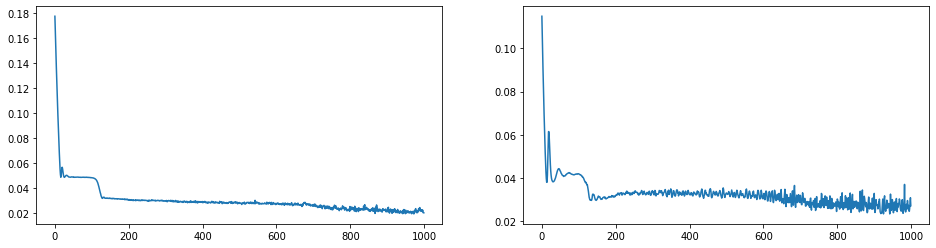

In [211]:
fig = plt.figure(figsize = [16, 4])
ax1 = fig.add_subplot(121)
ax1.plot(train_loss_set)
ax2 = fig.add_subplot(122)
ax2.plot(val_loss_set)

# 3. Evaluation

In [215]:
def mape_loss_func(preds, labels):
    try:
        if preds.device.type == 'cuda':
            preds = preds.cpu().detach().numpy()
        if labels.device.type == 'cuda':
            labels = labels.cpu().detach().numpy()
    except:
        None
        
    mask = labels > .05
    return np.mean(np.fabs(labels[mask]-preds[mask])/labels[mask])

def smape_loss_func(preds, labels):
    try:
        if preds.device.type == 'cuda':
            preds = preds.cpu().detach().numpy()
        if labels.device.type == 'cuda':
            labels = labels.cpu().detach().numpy()
    except:
        None
        
    mask= labels > .05
    return np.mean(2*np.fabs(labels[mask]-preds[mask])/(np.fabs(labels[mask])+np.fabs(preds[mask])))

def mae_loss_func(preds, labels):
    try:
        if preds.device.type == 'cuda':
            preds = preds.cpu().detach().numpy()
        if labels.device.type == 'cuda':
            labels = labels.cpu().detach().numpy()
    except:
        None
        
    mask= labels > .05
    return np.fabs((labels[mask]-preds[mask])).mean()

def eliminate_nan(b):
    a = np.array(b)
    c = a[~np.isnan(a)]
    return c

In [216]:
net.eval()

print('MAPE: %.5f'%mape_loss_func(val_out, Yt_valid))
print('SMAPE: %.5f'%smape_loss_func(val_out, Yt_valid))
print('MAE: %.5f'%mae_loss_func(val_out, Yt_valid))

MAPE: 0.63918
SMAPE: 0.42252
MAE: 0.13035
